In [3]:
"""
Function: compute_voxel_sizes
-----------------------------
Given a file path to an NRRD file, this function reads the file 
header and computes the voxel sizes from the 'space directions' field.
If no valid 'space directions' field is found, it will issue a warning.
"""

import nrrd
import numpy as np

def compute_voxel_sizes(nrrd_file_path):
    # Read the NRRD file (data + header)
    _, header = nrrd.read(nrrd_file_path)
    
    # Check if 'space directions' is in the header
    if 'space directions' in header:
        space_directions = header['space directions']
        voxel_sizes = []
        
        for direction in space_directions:
            if direction is not None:
                # Compute the Euclidean norm (length) of the direction vector
                voxel_size = np.linalg.norm(direction)
            else:
                # If a direction is None, set voxel_size to None or handle appropriately
                voxel_size = None
            voxel_sizes.append(voxel_size)
        
        return voxel_sizes
    else:
        print("Warning: 'space directions' not found in the header. Unable to compute voxel size.")
        return None

compute_voxel_sizes("/home/mariopasc/Python/Datasets/Meningiomas/Meningioma_Adquisition/RM/T1/P50/T1_P50.nrrd")

[np.float64(0.507799983025),
 np.float64(0.507799983025),
 np.float64(0.9000015258789062)]

# 3d

In [6]:
import numpy as np
import cv2
from scipy import ndimage
from typing import Tuple

def load_volume_and_mask(
    filepath: str,
    threshold_method: str = "li",
    structure_size_2d: int = 7,
    iterations_2d: int = 3,
    structure_size_3d: int = 3,
    iterations_3d: int = 1
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load a 3D volume from an NPZ file and generate a volumetric exclusion mask (brain/skull)
    by applying:
        1) Global normalization to [0, 255].
        2) Thresholding per slice.
        3) Largest contour + convex hull (slice by slice).
        4) 2D morphological closing on each slice.
        5) (Optional) 3D morphological closing across slices.
        6) Keep only the largest connected component in 3D.

    Parameters
    ----------
    filepath : str
        Path to the NPZ file containing the volume data.
    threshold_method : str, optional
        Thresholding method for each slice (e.g., "li", "otsu"), by default "li".
    structure_size_2d : int, optional
        Size of the structuring element for 2D morphological closing, by default 7.
    iterations_2d : int, optional
        Number of iterations for 2D morphological closing, by default 3.
    structure_size_3d : int, optional
        Size of the structuring element for 3D morphological closing, by default 3.
    iterations_3d : int, optional
        Number of iterations for 3D morphological closing, by default 1.

    Returns
    -------
    volume : np.ndarray
        The original 3D volume (shape: [num_slices, height, width]).
    mask : np.ndarray
        A 3D boolean mask where True indicates the brain/skull region.
    """
    # ------------------
    # 1) Load and globally normalize
    # ------------------
    npz_data = np.load(filepath)
    volume = np.squeeze(npz_data["data"][0, :, :, :])  # shape: (num_slices, height, width)

    vmin, vmax = volume.min(), volume.max()
    if vmax - vmin < 1e-6:
        # Degenerate volume: return trivial mask
        mask = (volume > 0)
        return volume, mask.astype(bool)

    vol_norm = ((volume - vmin) / (vmax - vmin) * 255).astype(np.uint8)

    # ------------------
    # 2) Per-slice threshold, largest contour + convex hull
    # ------------------
    masks_2d = np.zeros_like(vol_norm, dtype=np.uint8)
    for i in range(vol_norm.shape[0]):
        slice_img = vol_norm[i, :, :]

        # Threshold (replace _threshold_slice with your actual function if needed)
        thresh_slice = _threshold_slice(slice_img, threshold_method)

        # Find contours
        contours, _ = cv2.findContours(thresh_slice, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue

        # Largest contour in 2D
        largest_contour = max(contours, key=cv2.contourArea)
        # Convex hull
        hull = cv2.convexHull(largest_contour)

        # Create filled hull mask
        hull_mask = np.zeros_like(slice_img, dtype=np.uint8)
        cv2.drawContours(hull_mask, [hull], -1, color=255, thickness=cv2.FILLED)

        # 3) 2D morphological closing
        kernel_2d = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (structure_size_2d, structure_size_2d))
        closed_mask = cv2.morphologyEx(hull_mask, cv2.MORPH_CLOSE, kernel_2d, iterations=iterations_2d)

        masks_2d[i, :, :] = closed_mask

    # Convert to boolean
    mask_3d = masks_2d > 0

    # ------------------
    # 4) (Optional) 3D morphological closing for consistency
    # ------------------
    if structure_size_3d > 1:
        struct_3d = ndimage.generate_binary_structure(3, 1)
        struct_3d = ndimage.iterate_structure(struct_3d, structure_size_3d)
        mask_3d = ndimage.binary_closing(mask_3d, structure=struct_3d, iterations=iterations_3d)

    # ------------------
    # 5) Keep only the largest connected 3D component
    # ------------------
    labeled_mask, num_labels = ndimage.label(mask_3d)
    if num_labels > 1:
        # Calculate size (number of voxels) in each label
        label_sizes = ndimage.sum(mask_3d, labeled_mask, range(1, num_labels + 1))
        # Find which label is largest
        largest_label = np.argmax(label_sizes) + 1
        # Keep only that label
        mask_3d = (labeled_mask == largest_label)

    return volume, mask_3d.astype(bool)


def _threshold_slice(slice_img: np.ndarray, method: str = "li") -> np.ndarray:
    """
    Threshold a single 2D slice (uint8) using the specified method.

    Parameters
    ----------
    slice_img : np.ndarray
        2D image array in uint8 format.
    method : str
        Threshold method, e.g., "li", "otsu".

    Returns
    -------
    np.ndarray
        Binary mask (uint8) from thresholding.
    """
    if method.lower() == "otsu":
        _, thr = cv2.threshold(slice_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return thr
    # If "li" or anything else, fallback to Otsu here for simplicity.
    _, thr = cv2.threshold(slice_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thr


In [8]:
import os 

output_folder = (
    "scripts/noise_modelling/gaussian_random_markov_fields/images/experiment_images"
)
os.makedirs(output_folder, exist_ok=True)

base_path = "/home/mariopasc/Python/Datasets/Meningiomas/Meningioma_Adquisition"
output_npz_path = "/home/mariopasc/Python/Datasets/Meningiomas/npz"

patient = "P50"
pulse = "T1"
filepath = os.path.join(output_npz_path, patient, f"{patient}_{pulse}.npz")

In [9]:
import numpy as np
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt

def debug_segmentation_steps(
    filepath: str,
    slice_idx: int,
    threshold_method: str = "li",
    structure_size_2d: int = 7,
    iterations_2d: int = 3,
    structure_size_3d: int = 3,
    iterations_3d: int = 1
) -> None:
    """
    Loads a 3D volume from 'filepath' (NPZ) assumed to have shape (H, W, S).
    It then:
      1) Normalizes the volume globally to [0, 255].
      2) Thresholds each slice.
      3) Finds the largest 2D contour, computes its convex hull, and does a 2D closing.
      4) Optionally does a 3D closing for overall consistency.
      5) Keeps only the largest connected component in 3D.

    Finally, it extracts and displays intermediate results for the user-specified slice_idx:
      - Original slice
      - Normalized slice
      - Thresholded slice
      - Convex hull of the largest contour (2D)
      - Final 3D mask for that slice

    Parameters
    ----------
    filepath : str
        Path to the NPZ file containing volume data (shape assumed: (H, W, S)).
    slice_idx : int
        Index of the slice to visualize (0 <= slice_idx < S).
    threshold_method : str, optional
        Thresholding method, e.g. "li" or "otsu", by default "li".
    structure_size_2d : int, optional
        Size of the structuring element for 2D morphological closing, by default 7.
    iterations_2d : int, optional
        Number of iterations for the 2D morphological closing, by default 3.
    structure_size_3d : int, optional
        Size of the structuring element for 3D morphological closing, by default 3.
    iterations_3d : int, optional
        Number of iterations for the 3D morphological closing, by default 1.
    """

    # ------------------------------------------------------------------
    # 1) LOAD VOLUME (Assuming shape is (H, W, S))
    # ------------------------------------------------------------------
    npz_data = np.load(filepath)
    # For example, if stored as npz_data["data"][0,...] => shape: (H, W, S) or (S, H, W).
    # Adjust to your actual shape. Below we assume (H, W, S).
    volume = np.squeeze(npz_data["data"][0])  # shape: (H, W, S) after squeeze

    if volume.ndim != 3:
        raise ValueError(f"Expected a 3D volume, but got shape {volume.shape}.")

    H, W, S = volume.shape
    if not (0 <= slice_idx < S):
        raise IndexError(f"slice_idx={slice_idx} is out of bounds for volume with {S} slices.")

    # Convert volume to float for normalization
    volume = volume.astype(np.float32, copy=False)
    vmin, vmax = volume.min(), volume.max()
    if vmax - vmin < 1e-6:
        print("Warning: Degenerate volume with almost no intensity range.")
        # We'll just show the slice as-is and produce an all-True or all-False mask.
        _debug_show_single_slice(
            original=volume[..., slice_idx],
            normalized=volume[..., slice_idx],
            thresholded=None,
            hull_mask=None,
            final_mask=(volume[..., slice_idx] > 0),
            slice_idx=slice_idx
        )
        return

    # ------------------------------------------------------------------
    # 2) GLOBAL NORMALIZATION [0..255]
    # ------------------------------------------------------------------
    vol_norm = ((volume - vmin) / (vmax - vmin) * 255).astype(np.uint8)

    # We'll keep track of intermediate 2D results for each slice:
    # thresholded_3d:  (H, W, S)
    # hull_3d:         (H, W, S)
    thresholded_3d = np.zeros((H, W, S), dtype=np.uint8)
    hull_3d        = np.zeros((H, W, S), dtype=np.uint8)

    # ------------------------------------------------------------------
    # 3) Process each slice independently (threshold + largest contour + hull + 2D close)
    # ------------------------------------------------------------------
    kernel_2d = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (structure_size_2d, structure_size_2d))

    for i in range(S):
        # Slice i from the normalized volume
        slice_i = vol_norm[..., i]

        # Threshold
        thr_i = _threshold_slice(slice_i, threshold_method)
        thresholded_3d[..., i] = thr_i

        # Find the largest contour
        contours, _ = cv2.findContours(thr_i, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            continue
        largest_contour = max(contours, key=cv2.contourArea)

        # Convex hull
        hull_pts = cv2.convexHull(largest_contour)
        hull_mask_slice = np.zeros_like(slice_i, dtype=np.uint8)
        cv2.drawContours(hull_mask_slice, [hull_pts], -1, color=255, thickness=cv2.FILLED)

        # 2D morphological closing
        hull_mask_closed = cv2.morphologyEx(hull_mask_slice, cv2.MORPH_CLOSE, kernel_2d, iterations=iterations_2d)
        hull_3d[..., i]  = hull_mask_closed

    # Convert hull_3d to boolean
    mask_3d = (hull_3d > 0)

    # ------------------------------------------------------------------
    # 4) Optional 3D morphological closing
    # ------------------------------------------------------------------
    if structure_size_3d > 1:
        struct_3d = ndimage.generate_binary_structure(3, 1)
        struct_3d = ndimage.iterate_structure(struct_3d, structure_size_3d)
        mask_3d = ndimage.binary_closing(mask_3d, structure=struct_3d, iterations=iterations_3d)

    # ------------------------------------------------------------------
    # 5) Keep only largest connected component in 3D
    # ------------------------------------------------------------------
    labeled, n_labels = ndimage.label(mask_3d)
    if n_labels > 1:
        label_sizes = ndimage.sum(mask_3d, labeled, range(1, n_labels + 1))
        largest_label = np.argmax(label_sizes) + 1
        mask_3d = (labeled == largest_label)

    # ------------------------------------------------------------------
    # Extract intermediate/final results for the requested slice
    # ------------------------------------------------------------------
    original_slice   = volume[..., slice_idx].astype(np.float32)
    normalized_slice = vol_norm[..., slice_idx]
    thresh_slice     = thresholded_3d[..., slice_idx]
    hull_slice       = hull_3d[..., slice_idx]
    final_slice_mask = mask_3d[..., slice_idx]

    # ------------------------------------------------------------------
    # Show everything in subplots
    # ------------------------------------------------------------------
    _debug_show_single_slice(
        original=original_slice,
        normalized=normalized_slice,
        thresholded=thresh_slice,
        hull_mask=hull_slice,
        final_mask=final_slice_mask,
        slice_idx=slice_idx
    )


def _threshold_slice(slice_img: np.ndarray, method: str = "li") -> np.ndarray:
    """
    Threshold a single 2D slice (uint8) using the specified method.

    Parameters
    ----------
    slice_img : np.ndarray
        2D image array in uint8 format.
    method : str
        Threshold method, e.g. "li" or "otsu".

    Returns
    -------
    np.ndarray
        Binary mask (uint8) from thresholding.
    """
    # Simple Otsu example
    if method.lower() == "otsu":
        _, thr = cv2.threshold(slice_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return thr
    # If method = "li" or unknown, we can do a fallback to Otsu or add scikit-image logic.
    _, thr = cv2.threshold(slice_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thr


def _debug_show_single_slice(
    original: np.ndarray,
    normalized: np.ndarray,
    thresholded: np.ndarray,
    hull_mask: np.ndarray,
    final_mask: np.ndarray,
    slice_idx: int
):
    """
    Helper to display a single slice at multiple stages:
      1) Original
      2) Normalized [0..255]
      3) Thresholded (binary)
      4) Hull mask (2D)
      5) Final mask (after 3D ops)

    We overlay the hull mask in red and the final mask in green for clarity.
    """
    fig, axes = plt.subplots(1, 5, figsize=(18, 4))

    # 1) Original
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('1) Original Slice')
    axes[0].axis('off')

    # 2) Normalized
    axes[1].imshow(normalized, cmap='gray')
    axes[1].set_title('2) Normalized [0..255]')
    axes[1].axis('off')

    # 3) Thresholded
    if thresholded is not None:
        axes[2].imshow(thresholded, cmap='gray')
        axes[2].set_title('3) Thresholded Slice')
    else:
        axes[2].set_title('3) Thresholded Slice\n(No data)')
    axes[2].axis('off')

    # 4) Hull mask overlay (red) on normalized
    if hull_mask is not None:
        overlay_hull = cv2.cvtColor(normalized, cv2.COLOR_GRAY2RGB)
        overlay_hull[hull_mask > 0] = [255, 0, 0]  # red
        axes[3].imshow(overlay_hull)
        axes[3].set_title('4) Hull (Largest Contour)')
    else:
        axes[3].set_title('4) Hull (No data)')
    axes[3].axis('off')

    # 5) Final mask overlay (green) on normalized
    if final_mask is not None:
        overlay_final = cv2.cvtColor(normalized, cv2.COLOR_GRAY2RGB)
        overlay_final[final_mask > 0] = [0, 255, 0]  # green
        axes[4].imshow(overlay_final)
        axes[4].set_title('5) Final 3D Mask')
    else:
        axes[4].set_title('5) Final 3D Mask (No data)')
    axes[4].axis('off')

    fig.suptitle(f"Segmentation Debug (Slice {slice_idx})", fontsize=16)
    plt.tight_layout()
    plt.show()


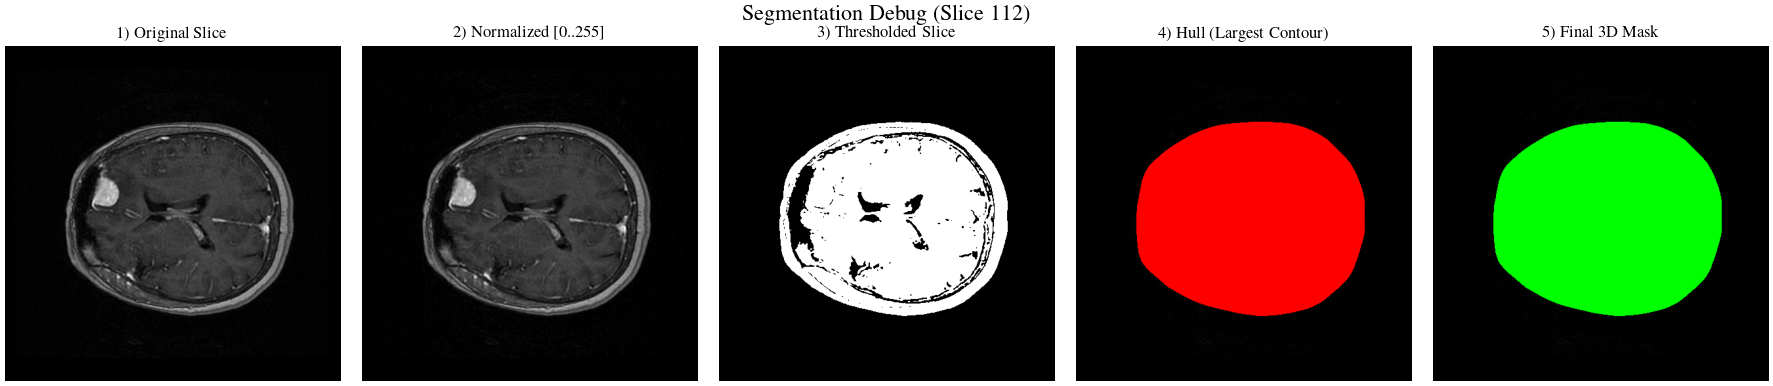

In [10]:
debug_segmentation_steps(
    filepath=filepath,
    slice_idx=112,
    threshold_method="otsu",    # or "li"
    structure_size_2d=7,
    iterations_2d=3,
    structure_size_3d=3,
    iterations_3d=1
)


Volume shape: (512, 512, 200)
Mask shape: (512, 512, 200)


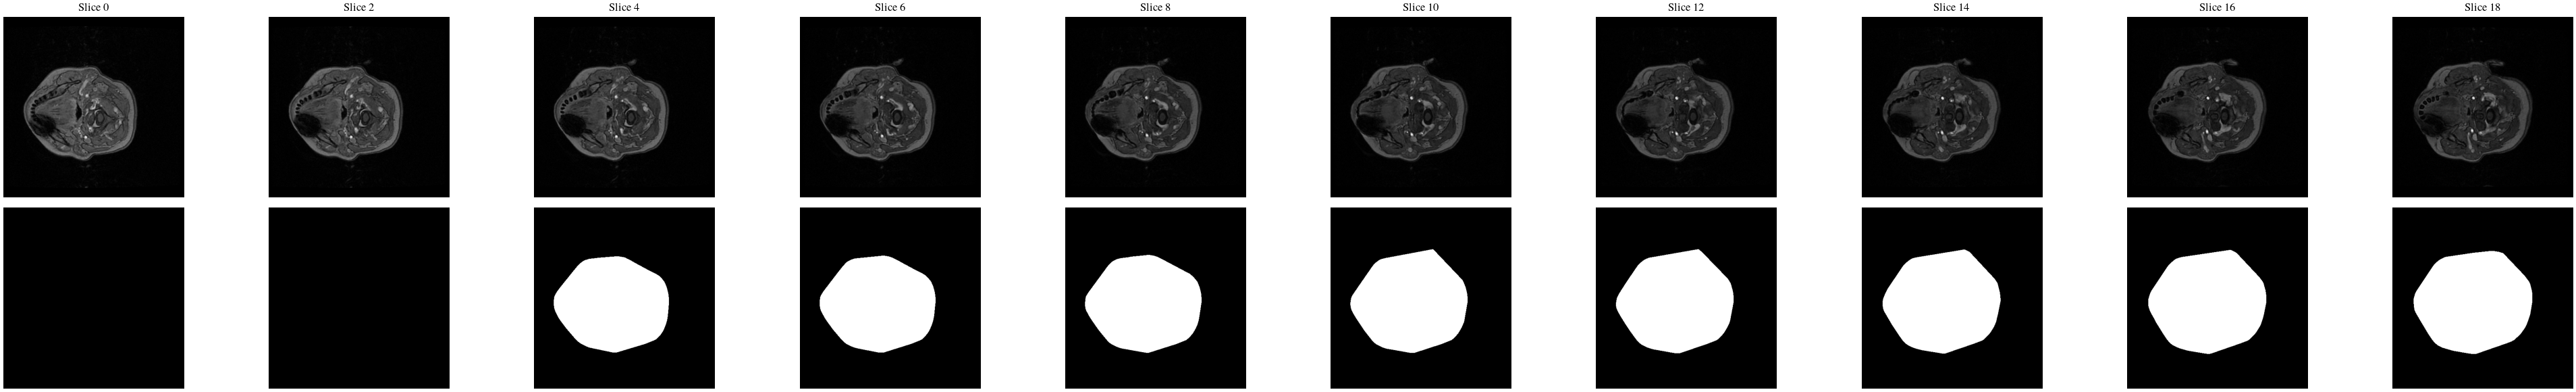

In [15]:
import numpy as np
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt
from typing import Tuple

def segment_volume(
    filepath: str,
    threshold_method: str = "otsu",
    structure_size_2d: int = 7,
    iterations_2d: int = 3,
    structure_size_3d: int = 3,
    iterations_3d: int = 1
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Implements the same segmentation pipeline as debug_segmentation_steps, but returns
    only the final (volume, mask) without displaying intermediate stages.

    Steps:
      1) Load volume from NPZ (assumed shape = (H, W, S) after squeeze).
      2) Global min-max normalization to [0, 255].
      3) For each slice:
          - Threshold (largest contour -> convex hull) + 2D morphological closing.
      4) (Optional) 3D morphological closing for inter-slice consistency.
      5) Largest 3D connected component is kept.
      6) Return the original volume (float32) and final mask (boolean).

    Parameters
    ----------
    filepath : str
        Path to the NPZ file. The volume is assumed in npz_data["data"][0], shape (H, W, S).
    threshold_method : str, optional
        Threshold method, e.g. "otsu" or "li". By default "otsu".
    structure_size_2d : int, optional
        Size of the kernel for 2D morphological closing. Default 7.
    iterations_2d : int, optional
        Number of iterations for 2D morphological closing. Default 3.
    structure_size_3d : int, optional
        Size of the kernel for 3D morphological closing. Default 3.
    iterations_3d : int, optional
        Number of iterations for the 3D morphological closing. Default 1.

    Returns
    -------
    volume : np.ndarray
        The loaded original volume (float32), shape (H, W, S).
    mask : np.ndarray
        A 3D boolean array (same shape as volume) with the segmented region = True.
    """
    # 1) Load volume
    npz_data = np.load(filepath)
    volume = np.squeeze(npz_data["data"][0])  # shape: (H, W, S) or (S, H, W) depending on dataset
    volume = volume.astype(np.float32, copy=False)

    # Check we have 3D data
    if volume.ndim != 3:
        raise ValueError(f"Expected a 3D volume, got shape {volume.shape}.")

    # 2) Global normalization
    vmin, vmax = volume.min(), volume.max()
    if vmax - vmin < 1e-6:
        # Degenerate volume, create a trivial mask
        mask = (volume > 0).astype(bool)
        return volume, mask

    vol_norm = ((volume - vmin) / (vmax - vmin) * 255).astype(np.uint8)

    H, W, S = volume.shape

    # Arrays to store intermediate results for each slice
    hull_3d = np.zeros((H, W, S), dtype=np.uint8)

    # 3) Per-slice threshold + largest contour + hull + 2D closing
    kernel_2d = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (structure_size_2d, structure_size_2d))

    for i in range(S):
        slice_i = vol_norm[..., i]
        thr_i = _threshold_slice(slice_i, threshold_method)

        contours, _ = cv2.findContours(thr_i, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue

        largest_contour = max(contours, key=cv2.contourArea)
        hull_pts = cv2.convexHull(largest_contour)

        hull_mask_slice = np.zeros_like(slice_i, dtype=np.uint8)
        cv2.drawContours(hull_mask_slice, [hull_pts], -1, color=255, thickness=cv2.FILLED)

        # 2D morphological closing
        hull_closed = cv2.morphologyEx(hull_mask_slice, cv2.MORPH_CLOSE, kernel_2d, iterations=iterations_2d)
        hull_3d[..., i] = hull_closed

    # Convert to boolean
    mask_3d = (hull_3d > 0)

    # 4) Optional 3D morphological closing
    if structure_size_3d > 1:
        struct_3d = ndimage.generate_binary_structure(3, 1)
        struct_3d = ndimage.iterate_structure(struct_3d, structure_size_3d)
        mask_3d = ndimage.binary_closing(mask_3d, structure=struct_3d, iterations=iterations_3d)

    # 5) Keep only the largest connected 3D component
    labeled, n_labels = ndimage.label(mask_3d)
    if n_labels > 1:
        label_sizes = ndimage.sum(mask_3d, labeled, range(1, n_labels + 1))
        largest_label = np.argmax(label_sizes) + 1
        mask_3d = (labeled == largest_label)

    return volume, mask_3d.astype(bool)


def _threshold_slice(slice_img: np.ndarray, method: str = "otsu") -> np.ndarray:
    """
    Threshold a single 2D slice (uint8) using the specified method.

    Parameters
    ----------
    slice_img : np.ndarray
        2D image array in uint8 format.
    method : str
        Threshold method, e.g. "otsu" or "li".

    Returns
    -------
    np.ndarray
        Binary mask (uint8) from thresholding.
    """
    if method.lower() == "otsu":
        _, thr = cv2.threshold(slice_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return thr
    # If "li" or unknown, fallback to Otsu
    _, thr = cv2.threshold(slice_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thr


def show_slices(
    volume: np.ndarray, 
    mask: np.ndarray, 
    start_slice: int = 50, 
    step: int = 10, 
    n_slices: int = 10
) -> None:
    """
    Display multiple slices from 'volume' and their corresponding segmentation in 'mask'.
    Top row = raw volume slice (grayscale).
    Bottom row = mask slice (grayscale).

    Parameters
    ----------
    volume : np.ndarray
        3D volume, shape (H, W, S) or (S, H, W).
    mask : np.ndarray
        3D binary (or 0/1) mask, same shape as volume.
    start_slice : int, optional
        First slice to display, by default 50.
    step : int, optional
        Step between consecutive slices, by default 10.
    n_slices : int, optional
        Number of slices to display, by default 10.
    """
    # Print shapes for reference
    print("Volume shape:", volume.shape)
    print("Mask shape:", mask.shape)

    # We assume (H, W, S). If your volume is (S, H, W), swap indexing accordingly.
    # E.g., if volume has shape (S, H, W), you'd do volume[slice_index, :, :].
    if volume.ndim != 3:
        raise ValueError(f"Expected a 3D volume, got shape {volume.shape}.")

    # Create a figure with 2 rows and n_slices columns
    fig, ax = plt.subplots(2, n_slices, figsize=(4 * n_slices, 6))

    H, W, S = volume.shape

    for j in range(n_slices):
        current_slice = start_slice + step * j
        if current_slice >= S:
            break  # Avoid out-of-bounds

        # Top row: volume slice
        ax[0, j].imshow(volume[:, :, current_slice], cmap="gray")
        ax[0, j].set_title(f"Slice {current_slice}")
        ax[0, j].axis('off')

        # Bottom row: mask slice
        ax[1, j].imshow(mask[:, :, current_slice], cmap="gray")
        ax[1, j].axis('off')

    plt.tight_layout()
    plt.show()

# 1) Segment the volume using the pipeline (no figures shown)
volume, mask = segment_volume(
    filepath=filepath,
    threshold_method="li",    # or "li"
    structure_size_2d=7,
    iterations_2d=3,
    structure_size_3d=3,
    iterations_3d=1
)

# 2) Visualize a range of slices
show_slices(
    volume=volume,
    mask=mask,
    start_slice=0,  # for instance
    step=2,
    n_slices=10
)


/home/mariopasc/Python/misc/miniconda3/envs/meningiomas/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:8751: RuntimeWarning: overflow encountered in divide
  s3 = (1/xm).sum()


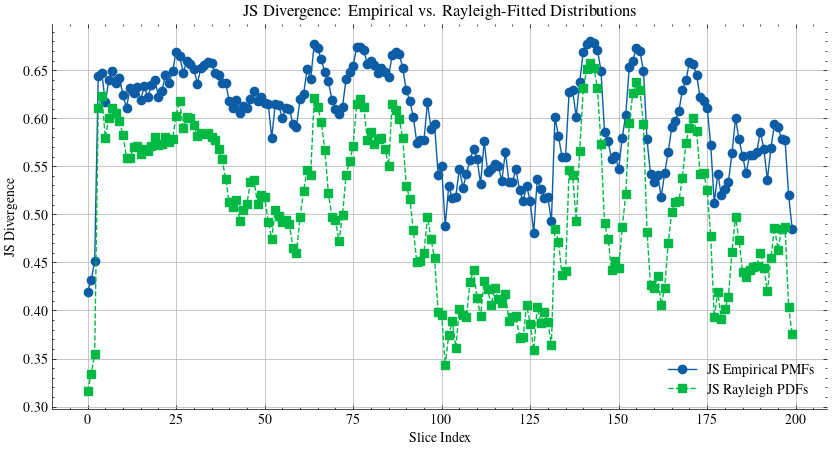

In [17]:
from scipy.stats import rayleigh
from Meningioma import Metrics
# Define function to compute empirical PMFs using histogram binning
def compute_empirical_pmf(data, bins_common):
    """Computes empirical probability mass function (PMF) using histogram binning."""
    hist, _ = np.histogram(data, bins=bins_common, density=False)
    pmf = hist / hist.sum()
    return pmf

# Define function to fit Rayleigh distribution and compute theoretical PDF
def compute_rayleigh_pdf(data, bin_centers):
    """Fits a Rayleigh distribution to data and computes its theoretical PDF."""
    loc, scale = rayleigh.fit(data)  # Fit Rayleigh distribution
    pdf = rayleigh.pdf(bin_centers, loc=loc, scale=scale)
    return pdf

# Base directory containing all slices
base_dir = "/home/mariopasc/Python/Results/Meningioma/noise_modelling/variogram_models_fitting/P50/Noise_Comparison/T1"

# Store computed JS divergences for empirical and Rayleigh distributions
slice_indices = []
js_empirical_values = []
js_rayleigh_values = []

# Process each slice
for slice_dir in slice_dirs:
    json_path = os.path.join(base_dir, slice_dir, "42.json")
    
    if os.path.exists(json_path):
        # Load JSON file
        with open(json_path, "r") as f:
            data = json.load(f)

        # Extract original data values from KDE-estimated PDFs (assuming x-values correspond to bin positions)
        x_values = np.array(data["pdf_background"]["x"])
        pdf_background = np.array(data["pdf_background"]["kde_est"])
        pdf_generated = np.array(data["pdf_generated"]["kde_est"])

        # Estimate data points by inverting the KDE values (not available directly in JSON)
        original_bg = np.repeat(x_values, (pdf_background * 1000).astype(int))
        generated_noise = np.repeat(x_values, (pdf_generated * 1000).astype(int))

        # Determine common bins
        min_val = np.floor(min(np.min(original_bg), np.min(generated_noise)))
        max_val = np.ceil(max(np.max(original_bg), np.max(generated_noise)))
        bins_common = np.arange(min_val, max_val + 2) - 0.5
        bin_centers = (bins_common[:-1] + bins_common[1:]) / 2

        # Compute empirical PMFs
        emp_pmf_bg = compute_empirical_pmf(original_bg, bins_common)
        emp_pmf_gen = compute_empirical_pmf(generated_noise, bins_common)

        # Compute Rayleigh PDFs
        rayleigh_pdf_bg = compute_rayleigh_pdf(original_bg, bin_centers)
        rayleigh_pdf_gen = compute_rayleigh_pdf(generated_noise, bin_centers)

        # Compute JS divergence for empirical PMFs
        js_empirical = Metrics.compute_jensen_shannon_divergence_pdfs(
            emp_pmf_bg, emp_pmf_gen, bin_centers
        )

        # Compute JS divergence for Rayleigh PDFs
        js_rayleigh = Metrics.compute_jensen_shannon_divergence_pdfs(
            rayleigh_pdf_bg, rayleigh_pdf_gen, bin_centers
        )

        # Store results
        slice_indices.append(int(slice_dir.split("_")[1]))
        js_empirical_values.append(js_empirical)
        js_rayleigh_values.append(js_rayleigh)

# Sort by slice index
sorted_indices = np.argsort(slice_indices)
slice_indices = np.array(slice_indices)[sorted_indices]
js_empirical_values = np.array(js_empirical_values)[sorted_indices]
js_rayleigh_values = np.array(js_rayleigh_values)[sorted_indices]

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(slice_indices, js_empirical_values, marker='o', linestyle='-', label="JS Empirical PMFs")
plt.plot(slice_indices, js_rayleigh_values, marker='s', linestyle='--', label="JS Rayleigh PDFs")
plt.xlabel("Slice Index")
plt.ylabel("JS Divergence")
plt.title("JS Divergence: Empirical vs. Rayleigh-Fitted Distributions")
plt.legend()
plt.grid()
plt.show()
